In [2]:
import torch
from torch.autograd import grad
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd 
import numpy as np

torch.manual_seed(1234)

In [3]:
#read data

covid_daily_cases = pd.read_csv('covid_real_data_daily_cases.csv', delimiter=',') #in the form of [t, I,D,R]
covid_daily_cases.columns = ['t', 'daily_infected', 'daily_dead', 'daily_recovered'] #rename columns
covid_daily_cases['t'] = covid_daily_cases['t'].astype(float)
covid_daily_cases

,t,daily_infected,daily_dead,daily_recovered
0,0.0,25272,1546,11785.0
1,1.0,27087,2305,6484.0
2,2.0,28859,2478,6093.0
3,3.0,31281,4616,5234.0
4,4.0,32084,3879,5904.0
...,...,...,...,...
489,489.0,38482,170,0.0
490,490.0,210168,686,0.0
491,491.0,128933,1001,0.0
492,492.0,137815,1146,0.0


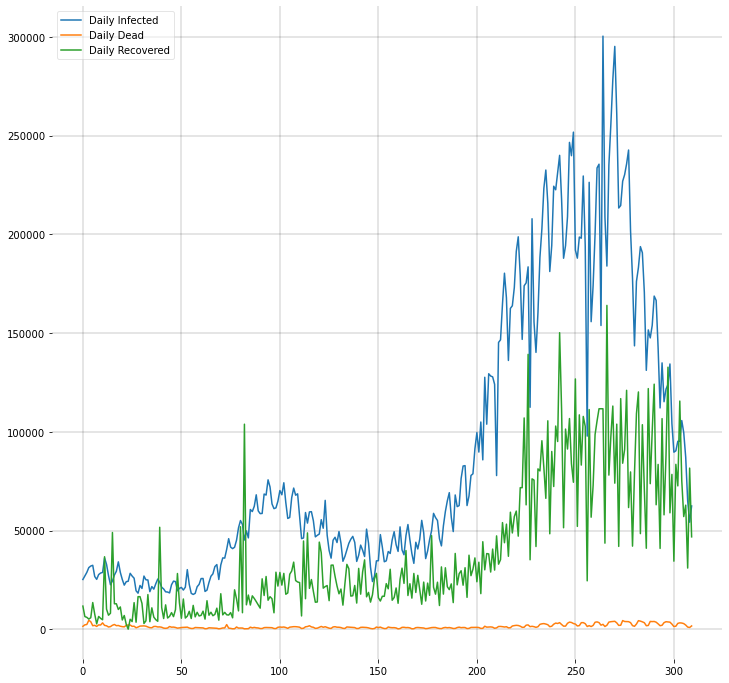

In [4]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

plt.plot(covid_daily_cases['daily_infected'][:310], label = 'Daily Infected')
plt.plot(covid_daily_cases['daily_dead'][:310], label = 'Daily Dead')
plt.plot(covid_daily_cases['daily_recovered'][:310], label = 'Daily Recovered')

ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show();

In [5]:
%%time

PATH = 'covid_real_data_daily_cases' 

class DINN(nn.Module):
    def __init__(self, t, I_data, D_data, R_data): #[t,I,D,R]
        super(DINN, self).__init__()
        self.N = 328e6 #population size
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.I = torch.tensor(I_data)
        self.D = torch.tensor(D_data)
        self.R = torch.tensor(R_data)

        self.losses = []
        self.save = 3 #which file to save to

        self.alpha_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.191
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.05
        self.gamma_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #0.0294
        
        #find values for normalization
        self.I_max = max(self.I)
        self.D_max = max(self.D)
        self.R_max = max(self.R)
        self.I_min = min(self.I)
        self.D_min = min(self.D)
        self.R_min = min(self.R)

        #unnormalize
        self.I_hat = (self.I - self.I_min) / (self.I_max - self.I_min)
        self.D_hat = (self.D - self.D_min) / (self.D_max - self.D_min)
        self.R_hat = (self.R - self.R_min) / (self.R_max - self.R_min)

        #matrices (x4 for S,I,D,R) for the gradients
        self.m1 = torch.zeros((len(self.t), 3)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 3)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 3)); self.m3[:, 2] = 1

        #NN
        self.net_sidr = self.Net_sidr()
        self.params = list(self.net_sidr.parameters())
        self.params.extend(list([self.alpha_tilda, self.beta_tilda, self.gamma_tilda]))

    #force parameters to be in a range
    @property
    def alpha(self):
        return torch.tanh(self.alpha_tilda)*0.191*200

    @property
    def beta(self):
        return torch.tanh(self.beta_tilda)*0.05*200
    
    @property
    def gamma(self):
        return torch.tanh(self.gamma_tilda)*0.0294*200

    #nets
    class Net_sidr(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_sidr, self).__init__()
            self.fc1=nn.Linear(1, 20) 
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 3) #outputs I, D, R

        def forward(self, t_batch):
            sidr=F.relu(self.fc1(t_batch))
            sidr=F.relu(self.fc2(sidr))
            sidr=F.relu(self.fc3(sidr))
            sidr=F.relu(self.fc4(sidr))
            sidr=F.relu(self.fc5(sidr))
            sidr=F.relu(self.fc6(sidr))
            sidr=F.relu(self.fc7(sidr))
            sidr=F.relu(self.fc8(sidr))
            sidr=self.out(sidr)
            return sidr
            
    def net_f(self, t_batch):
        sidr_hat = self.net_sidr(t_batch)

        I_hat, D_hat, R_hat = sidr_hat[:,0], sidr_hat[:,1], sidr_hat[:,2]

        #I_t
        sidr_hat.backward(self.m1, retain_graph=True)        
        I_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #D_t
        sidr_hat.backward(self.m2, retain_graph=True)        
        D_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #R_t
        sidr_hat.backward(self.m3, retain_graph=True)        
        R_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        I = self.I_min + (self.I_max - self.I_min) * I_hat
        D = self.D_min + (self.D_max - self.D_min) * D_hat      
        R = self.R_min + (self.R_max - self.R_min) * R_hat

        f2_hat = I_hat_t - ((self.alpha / self.N) * self.N * I - self.beta * I - self.gamma * I) / (self.I_max - self.I_min)
        f3_hat = D_hat_t - (self.gamma * I) / (self.D_max - self.D_min)
        f4_hat = R_hat_t - (self.beta * I ) / (self.R_max - self.R_min)

        return f2_hat, f3_hat, f4_hat, I_hat, D_hat, R_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
         
        self.losses = checkpoint['losses']
         
         

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        I_pred_list = []
        D_pred_list = []
        R_pred_list = []

         
        f2, f3, f4, I_pred, D_pred, R_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        I_pred_list.append(self.I_min + (self.I_max - self.I_min) * I_pred)
        D_pred_list.append(self.D_min + (self.D_max - self.D_min) * D_pred)
        R_pred_list.append(self.R_min + (self.R_max - self.R_min) * R_pred)

        loss = (torch.mean(torch.square(self.I_hat - I_pred))+
                torch.mean(torch.square(self.D_hat - D_pred))+
                torch.mean(torch.square(self.R_hat - R_pred))+
                torch.mean(torch.square(f2))+
                torch.mean(torch.square(f3))+
                torch.mean(torch.square(f4))
                ) 

         
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 100 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              #'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)

      return I_pred_list, D_pred_list, R_pred_list

CPU times: user 65 µs, sys: 0 ns, total: 65 µs
Wall time: 69.1 µs


In [18]:
%%time 
dinn = DINN(covid_daily_cases['t'][:310], covid_daily_cases['daily_infected'][:310], covid_daily_cases['daily_dead'][:310], covid_daily_cases['daily_recovered'][:310]
            ) #in the form of [t,S,I,D,R]

learning_rate = 1e-5
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

 
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  I_pred_list, D_pred_list, R_pred_list = dinn.train(20000) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    I_pred_list, D_pred_list, R_pred_list = dinn.train(20000) #train
  elif dinn.save == 3:
    dinn.save = 2
    I_pred_list, D_pred_list, R_pred_list = dinn.train(20000) #train


loading pre-trained model...

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.1538, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000

Saving model... Loss is:  tensor(0.1122, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  4000

Epoch  5000

Epoch  6000

Epoch  7000

Epoch  8000

Saving model... Loss is:  tensor(0.0452, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  8000

Epoch  9000

Epoch  10000

Epoch  11000

Epoch  12000

Saving model... Loss is:  tensor(0.0327, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  12000

Epoch  13000

Epoch  14000

Epoch  15000

Epoch  16000

Saving model... Loss is:  tensor(0.0322, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  16000

Epoch  17000

Epoch  18000

Epoch  19000
CPU times: user 1min 4s, sys: 81.8 ms, total: 1min 4s
Wall time: 1min 4s


Text(0, 0.5, 'Loss')

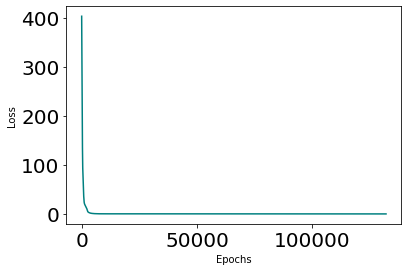

In [19]:
plt.plot(dinn.losses[0:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

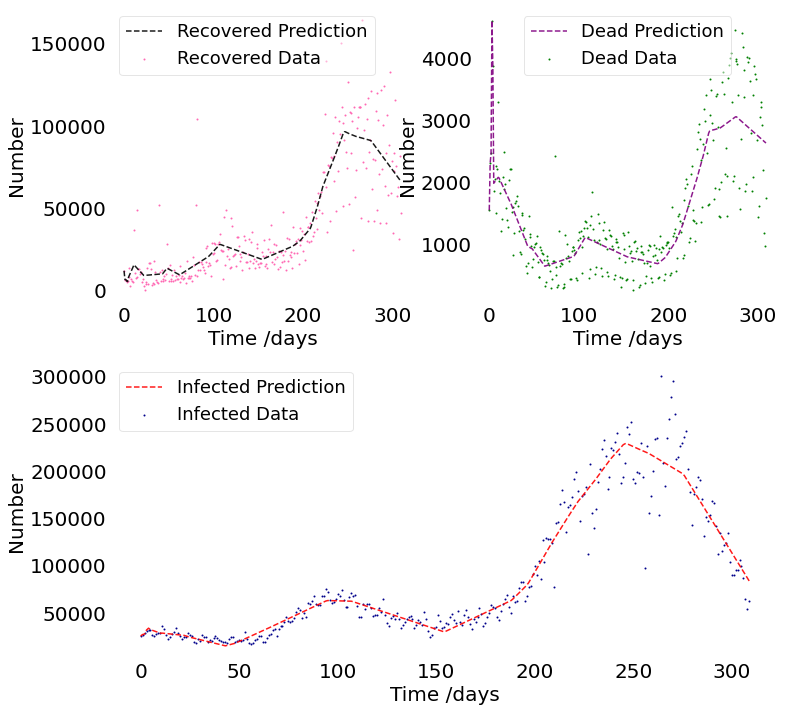

In [26]:
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec

plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

pl.figure(figsize=(12,12))
ax1 = pl.subplot(gs[0, 0]) # row 0, col 0
# pl.plot(covid_daily_cases['t'][:310], covid_daily_cases['daily_recovered'][:310], c = 'hotpink', alpha=0.5, lw=1, label='Recovered Data')
pl.scatter(covid_daily_cases['t'][:310], covid_daily_cases['daily_recovered'][:310], color = 'hotpink', label='Recovered Data', s=1)
pl.plot(covid_daily_cases['t'][:310], R_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=1.5, label='Recovered Prediction', linestyle='dashed')

ax2 = pl.subplot(gs[0, 1]) # row 0, col 1
# pl.plot(covid_daily_cases['t'][:310], covid_daily_cases['daily_dead'][:310], c = 'green', alpha=0.5, lw=1, label='Dead Data')
pl.scatter(covid_daily_cases['t'][:310], covid_daily_cases['daily_dead'][:310], color = 'green', label='Dead Data', s=1)
pl.plot(covid_daily_cases['t'][:310], D_pred_list[0].detach().numpy(), 'purple', alpha=0.9, lw=1.5, label='Dead Prediction', linestyle='dashed')


ax3 = pl.subplot(gs[1, :]) # row 1, span all columns
# pl.plot(covid_daily_cases['t'][:310], covid_daily_cases['daily_infected'][:310], c = 'darkblue', alpha=0.5, lw=1, label='Infected Data')
pl.scatter(covid_daily_cases['t'][:310], covid_daily_cases['daily_infected'][:310], color = 'darkblue', label='Infected Data', s=1)
pl.plot(covid_daily_cases['t'][:310], I_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=1.5, label='Infected Prediction', linestyle='dashed')


ax1.set_xlabel('Time /days',size = 20)
ax1.set_ylabel('Number',size = 20)
ax1.yaxis.set_tick_params(length=0)
ax1.xaxis.set_tick_params(length=0)
# ax1.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax1.legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax1.spines[spine].set_visible(False)
########################################################################
ax2.set_xlabel('Time /days',size = 20)
ax2.set_ylabel('Number',size = 20)
ax2.yaxis.set_tick_params(length=0)
ax2.xaxis.set_tick_params(length=0)
# ax2.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax2.legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax2.spines[spine].set_visible(False)
########################################################################
ax3.set_xlabel('Time /days',size = 20)
ax3.set_ylabel('Number',size = 20)
ax3.yaxis.set_tick_params(length=0)
ax3.xaxis.set_tick_params(length=0)
# ax3.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax3.legend(prop={'size':18})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax3.spines[spine].set_visible(False)
########################################################################

# plt.savefig('covid_real_data_daily_cases.pdf')
plt.show()